## Setup

In [29]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

## Built-in RNN layers: a simple example

There are three built-in RNN layers in Keras:

1. `keras.layers.SimpleRNN`, a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

2. `keras.layers.GRU`, first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).

3. `keras.layers.LSTM`, first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).

In early 2015, Keras had the first reusable open-source Python implementations of LSTM
and GRU.

Here is a simple example of a `Sequential` model that processes sequences of integers,
embeds each integer into a 64-dimensional vector, then processes the sequence of
vectors using a `LSTM` layer.

In [30]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Built-in RNNs support a number of useful features:

- Recurrent dropout, via the `dropout` and `recurrent_dropout` arguments
- Ability to process an input sequence in reverse, via the `go_backwards` argument
- Loop unrolling (which can lead to a large speedup when processing short sequences on
CPU), via the `unroll` argument
- ...and more.

For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).

## Outputs and states

By default, the output of a RNN layer contains a single vector per sample. This vector
is the RNN cell output corresponding to the last timestep, containing information
about the entire input sequence. The shape of this output is `(batch_size, units)`
where `units` corresponds to the `units` argument passed to the layer's constructor.

A RNN layer can also return the entire sequence of outputs for each sample (one vector
per timestep per sample), if you set `return_sequences=True`. The shape of this output
is `(batch_size, timesteps, units)`.

In [31]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In addition, a RNN layer can return its final internal state(s). The returned states
can be used to resume the RNN execution later, or
[to initialize another RNN](https://arxiv.org/abs/1409.3215).
This setting is commonly used in the
encoder-decoder sequence-to-sequence model, where the encoder final state is used as
the initial state of the decoder.

To configure a RNN layer to return its internal state, set the `return_state` parameter
to `True` when creating the layer. Note that `LSTM` has 2 state  tensors, but `GRU`
only has one.

To configure the initial state of the layer, just call the layer with additional
keyword argument `initial_state`.
Note that the shape of the state needs to match the unit size of the layer, like in the
example below.

In [32]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, None, 64)  │     64,000 │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, None, 64)  │    128,000 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder (LSTM)      │ [(None, 64),      │     33,024 │ embedding_10[0][… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder (LSTM)      │ (None, 64)        │     33,024 │ embedding_11[0][… │
│                     │                   │            │ encoder[0][1],    │
│                     │                   │            │ encoder[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 10)        │        650 │ decoder[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 258,698 (1010.54 KB)

 Trainable params: 258,698 (1010.54 KB)

 Non-trainable params: 0 (0.00 B)

## RNN layers and RNN cells

In addition to the built-in RNN layers, the RNN API also provides cell-level APIs.
Unlike RNN layers, which processes whole batches of input sequences, the RNN cell only
processes a single timestep.

The cell is the inside of the `for` loop of a RNN layer. Wrapping a cell inside a
`keras.layers.RNN` layer gives you a layer capable of processing batches of
sequences, e.g. `RNN(LSTMCell(10))`.

Mathematically, `RNN(LSTMCell(10))` produces the same result as `LSTM(10)`. In fact,
the implementation of this layer in TF v1.x was just creating the corresponding RNN
cell and wrapping it in a RNN layer.  However using the built-in `GRU` and `LSTM`
layers enable the use of CuDNN and you may see better performance.

There are three built-in RNN cells, each of them corresponding to the matching RNN
layer.

- `keras.layers.SimpleRNNCell` corresponds to the `SimpleRNN` layer.

- `keras.layers.GRUCell` corresponds to the `GRU` layer.

- `keras.layers.LSTMCell` corresponds to the `LSTM` layer.

The cell abstraction, together with the generic `keras.layers.RNN` class, make it
very easy to implement custom RNN architectures for your research.

## Cross-batch statefulness

When processing very long sequences (possibly infinite), you may want to use the
pattern of **cross-batch statefulness**.

Normally, the internal state of a RNN layer is reset every time it sees a new batch
(i.e. every sample seen by the layer is assumed to be independent of the past). The
layer will only maintain a state while processing a given sample.

If you have very long sequences though, it is useful to break them into shorter
sequences, and to feed these shorter sequences sequentially into a RNN layer without
resetting the layer's state. That way, the layer can retain information about the
entirety of the sequence, even though it's only seeing one sub-sequence at a time.

You can do this by setting `stateful=True` in the constructor.

If you have a sequence `s = [t0, t1, ... t1546, t1547]`, you would split it into e.g.

```
s1 = [t0, t1, ... t100]
s2 = [t101, ... t201]
...
s16 = [t1501, ... t1547]
```

Then you would process it via:

```python
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
  output = lstm_layer(s)
```

When you want to clear the state, you  can use `layer.reset_states()`.


> Note: In this setup, sample `i` in a given batch is assumed to be the continuation of
sample `i` in the previous batch. This means that all batches should contain the same
number of samples (batch size). E.g. if a batch contains `[sequence_A_from_t0_to_t100,
 sequence_B_from_t0_to_t100]`, the next batch should contain
`[sequence_A_from_t101_to_t200,  sequence_B_from_t101_to_t200]`.




Here is a complete example:

In [33]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()


### RNN State Reuse
<a id="rnn_state_reuse"></a>

The recorded states of the RNN layer are not included in the `layer.weights()`. If you
would like to reuse the state from a RNN layer, you can retrieve the states value by
`layer.states` and use it as the
initial state for a new layer via the Keras functional API like `new_layer(inputs,
initial_state=layer.states)`, or model subclassing.

Please also note that sequential model might not be used in this case since it only
supports layers with single input and output, the extra input of initial state makes
it impossible to use here.

In [34]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=existing_state)


## Bidirectional RNNs

For sequences other than time series (e.g. text), it is often the case that a RNN model
can perform better if it not only processes sequence from start to end, but also
backwards. For example, to predict the next word in a sentence, it is often useful to
have the context around the word, not only just the words that come before it.

Keras provides an easy API for you to build such bidirectional RNNs: the
`keras.layers.Bidirectional` wrapper.

In [35]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 5, 128)         │        38,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,266 (313.54 KB)

 Trainable params: 80,266 (313.54 KB)

 Non-trainable params: 0 (0.00 B)

Under the hood, `Bidirectional` will copy the RNN layer passed in, and flip the
`go_backwards` field of the newly copied layer, so that it will process the inputs in
reverse order.

The output of the `Bidirectional` RNN will be, by default, the concatenation of the forward layer
output and the backward layer output. If you need a different merging behavior, e.g.
concatenation, change the `merge_mode` parameter in the `Bidirectional` wrapper
constructor. For more details about `Bidirectional`, please check
[the API docs](https://keras.io/api/layers/recurrent_layers/bidirectional/).

## Performance optimization and CuDNN kernels

In TensorFlow 2.0, the built-in LSTM and GRU layers have been updated to leverage CuDNN
kernels by default when a GPU is available. With this change, the prior
`keras.layers.CuDNNLSTM/CuDNNGRU` layers have been deprecated, and you can build your
model without worrying about the hardware it will run on.

Since the CuDNN kernel is built with certain assumptions, this means the layer **will
not be able to use the CuDNN kernel if you change the defaults of the built-in LSTM or
GRU layers**. E.g.:

- Changing the `activation` function from `tanh` to something else.
- Changing the `recurrent_activation` function from `sigmoid` to something else.
- Using `recurrent_dropout` > 0.
- Setting `unroll` to True, which forces LSTM/GRU to decompose the inner
`tf.while_loop` into an unrolled `for` loop.
- Setting `use_bias` to False.
- Using masking when the input data is not strictly right padded (if the mask
corresponds to strictly right padded data, CuDNN can still be used. This is the most
common case).

For the detailed list of constraints, please see the documentation for the
[LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) and
[GRU](https://keras.io/api/layers/recurrent_layers/gru/) layers.

### Using CuDNN kernels when available

Let's build a simple LSTM model to demonstrate the performance difference.

We'll use as input sequences the sequence of rows of MNIST digits (treating each row of
pixels as a timestep), and we'll predict the digit's label.

In [36]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9


# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model


Let's load the MNIST dataset:

In [37]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

Let's create a model instance and train it.

We choose `sparse_categorical_crossentropy` as the loss function for the model. The
output of the model has shape of `[batch_size, 10]`. The target for the model is an
integer vector, each of the integer is in the range of 0 to 9.

In [38]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5518 - loss: 1.3581 - val_accuracy: 0.8317 - val_loss: 0.5331


Now, let's compare to a model that does not use the CuDNN kernel:

In [39]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.8569 - loss: 0.4680 - val_accuracy: 0.9044 - val_loss: 0.3040


When running on a machine with a NVIDIA GPU and CuDNN installed,
the model built with CuDNN is much faster to train compared to the
model that uses the regular TensorFlow kernel.

The same CuDNN-enabled model can also be used to run inference in a CPU-only
environment. The `tf.device` annotation below is just forcing the device placement.
The model will run on CPU by default if no GPU is available.

You simply don't have to worry about the hardware you're running on anymore. Isn't that
pretty cool?

Predicted result is: [3], target result is: 5


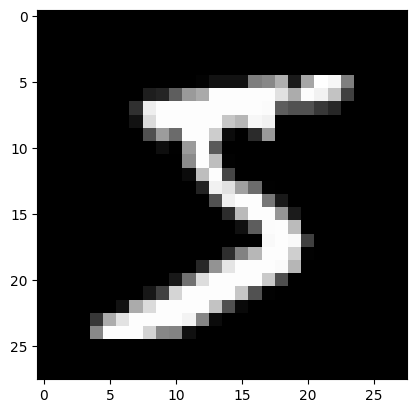

In [40]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

## RNNs with list/dict inputs, or nested inputs

Nested structures allow implementers to include more information within a single
timestep. For example, a video frame could have audio and video input at the same
time. The data shape in this case could be:

`[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]`

In another example, handwriting data could have both coordinates x and y for the
current position of the pen, as well as pressure information. So the data
representation could be:

`[batch, timestep, {"location": [x, y], "pressure": [force]}]`

The following code provides an example of how to build a custom RNN cell that accepts
such structured inputs.

### Define a custom cell that supports nested input/output

See [Making new Layers & Models via subclassing](/guides/making_new_layers_and_models_via_subclassing/)
for details on writing your own layers.

In [41]:
@keras.saving.register_keras_serializable()
class NestedCell(keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        # Set state_size and output_size explicitly as lists of integers
        self.state_size = [unit_1, unit_2 * unit_3]
        self.output_size = unit_1 + (unit_2 * unit_3)
        super().__init__(**kwargs)

    def build(self, input_shape):
        # Assume input shape: (batch, timestep, features)
        # i1 represents the dimension of input_1, and the rest is for input_2
        i1 = input_shape[-1] - (self.unit_2 * self.unit_3)

        # Define weights for transformation
        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer="uniform", name="kernel_1"
        )
        self.kernel_2_3 = self.add_weight(
            shape=(self.unit_2, self.unit_3, self.unit_2, self.unit_3),
            initializer="uniform",
            name="kernel_2_3",
        )

    def call(self, inputs, states):
        # Ensure the input tensor is sliced correctly
        input_1_size = self.unit_1
        input_2_size = self.unit_2 * self.unit_3

        # Separate inputs into input_1 and input_2
        input_1 = inputs[:, :input_1_size]  # First part
        input_2 = inputs[:, input_1_size:input_1_size + input_2_size]  # Remaining part for input_2
        input_2 = tf.reshape(input_2, (-1, self.unit_2, self.unit_3))  # Reshape to (batch, unit_2, unit_3)

        # Retrieve previous states
        s1, s2 = states

        # Compute outputs
        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)

        # Reshape output_2_3 to match s2 for the addition
        output_2_3_reshaped = tf.reshape(output_2_3, (-1, self.unit_2 * self.unit_3))

        # Concatenate outputs along the last dimension
        output = tf.concat([output_1, output_2_3_reshaped], axis=-1)

        # Update states
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3_reshaped  # Ensure compatible shape
        new_states = (state_1, state_2_3)

        return output, new_states



    def get_config(self):
        return {"unit_1": self.unit_1, "unit_2": self.unit_2, "unit_3": self.unit_3}

### Build a RNN model with nested input/output

Let's build a Keras model that uses a `keras.layers.RNN` layer and the custom cell
we just defined.

In [42]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Assume NestedCell is defined here

# Define parameters
batch_size = 32
timesteps = 10
units_1 = 5
units_2 = 3
units_3 = 2
input_dim = units_1 + (units_2 * units_3)  # Adjusted input_dim


# Generate random training data
x_train = np.random.random((1000, timesteps, input_dim)).astype(np.float32)
y_train = np.random.random((1000, units_1 + (units_2 * units_3))).astype(np.float32)

# Instantiate the custom RNN layer
class CustomRNN(keras.layers.RNN):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        super().__init__(NestedCell(unit_1, unit_2, unit_3), **kwargs)

# Define the model using the custom RNN layer
inputs = keras.Input(shape=(timesteps, input_dim))
x = CustomRNN(units_1, units_2, units_3, return_sequences=False)(inputs)
outputs = keras.layers.Dense(units_1 + (units_2 * units_3), activation="linear")(x)

model = keras.models.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="adam", loss="mse")

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=10)

# Print training results
print("Training complete. Final loss:", history.history["loss"][-1])


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3191
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2346
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1527
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1010
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0910
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0904
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0888
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0900
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0906
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0888
Training complete. Final loss: 0.08934759348630905
